Full well depth
---------------

Pick a point in the three different voltage nights which have similar:

* airmass
* sky background
* airglow

Then perform the tests:
* Compute histograms of the pixel values in raw frames and plot:
    * position of maximum value
    * position of first peak
  as function of voltage
  
<table>
<tr>
<th>Actions</th>
<th>Night</th>
<th>VI+</th>
</tr>
<tr>
<td>104357, 104358</td>
<td>20150609</td>
<td>122</td>
</tr>
<tr>
<td>104400, 104401</td>
<td>20150610</td>
<td>223</td>
</tr>
<tr>
<td>104439, 104440</td>
<td>20160611</td>
<td>168</td>
</tr>
</table>

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns
import os

%aimport full_well_depth
f = full_well_depth


sns.set(style='white', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Start by looking at the night conditions. We want to see airmass, sky background and airglow. Pick the NG2000 field as this has its zenith later in the night: ![Object visibility chart for 802](https://ngts.warwick.ac.uk/prnl/prism/monitor/img/vis_802.png)

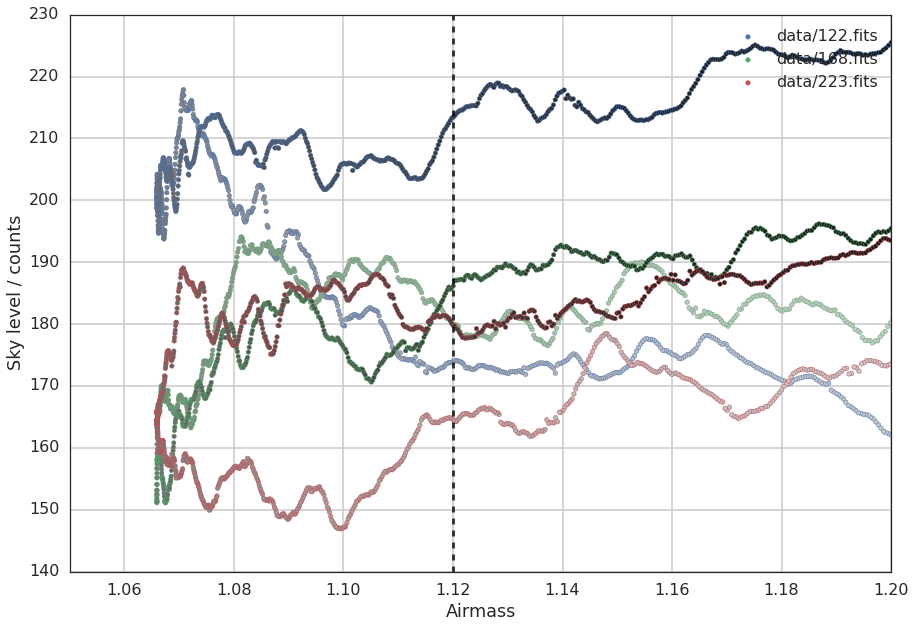

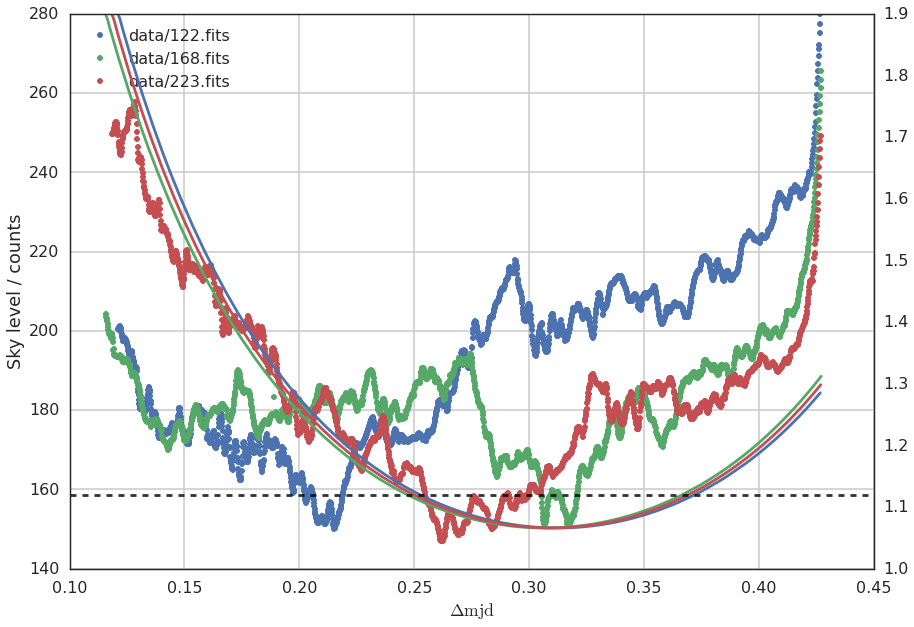

In [2]:
optimal_airmass = f.assess_sky_background_levels()

In [3]:
print('Optimal airmass: {}'.format(optimal_airmass))

Optimal airmass: 1.12


In [4]:
image_ids = f.get_image_ids(optimal_airmass)
print(image_ids)

{'data/122.fits': {'image_id': 80220150610060325}, 'data/168.fits': {'image_id': 80220150612055542}, 'data/223.fits': {'image_id': 80220150611055928}}


In [5]:
for key in image_ids:
    image_id = image_ids[key]['image_id']
    image_ids[key]['raw_image_data'] = raw_image_data = f.fetch_image_data(image_id)
    image_ids[key]['prescan'] = prescan = raw_image_data[4:, :20].mean()
    image_ids[key]['overscan'] = overscan = raw_image_data[4:, -15:].mean()
    image_ids[key]['overscan-prescan'] = overscan - prescan
    image_ids[key]['bias_subtracted'] = raw_image_data[:, 20:-20] - overscan
    image_ids[key]['label'] = os.path.basename(key).replace('.fits', '')

In [6]:
bins = np.logspace(3, 5, 500)

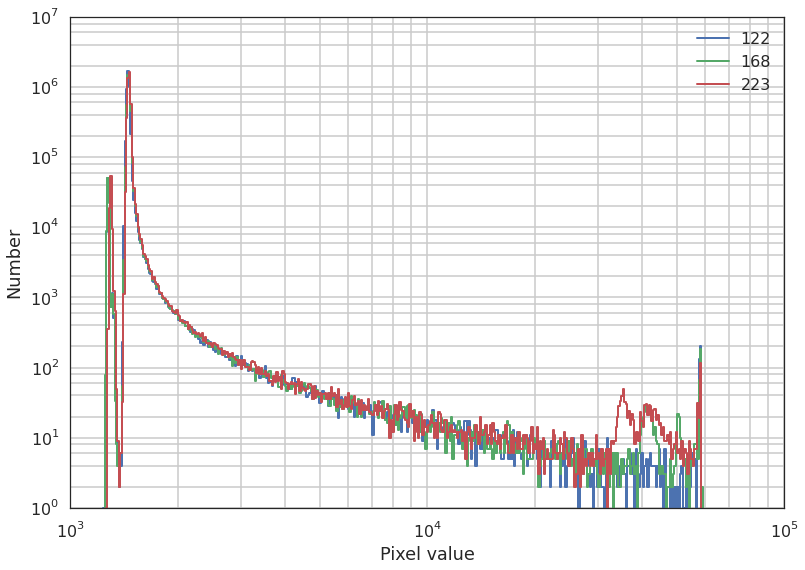

In [7]:
fig, axis = plt.subplots()
f.image_histogram(image_ids, axis, bins);

Zoom in to the bright end:

[(1.0, 1000.0), (10000.0, 100000.0)]

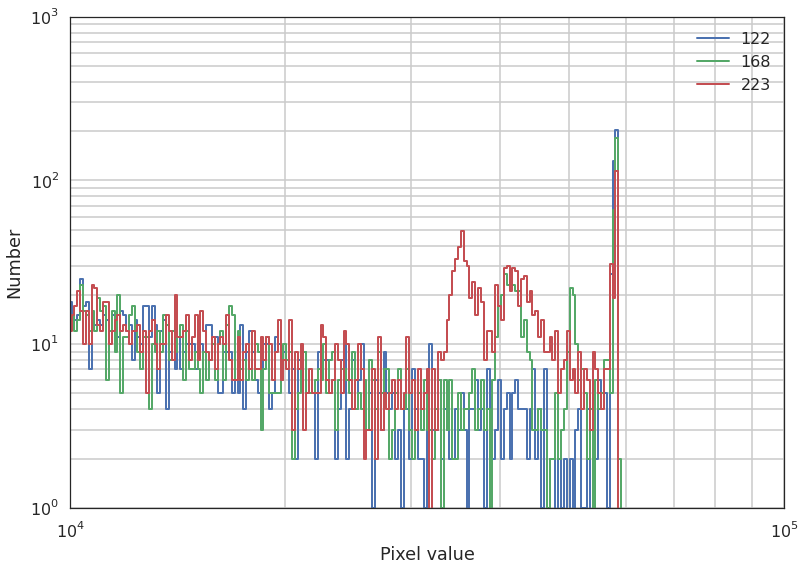

In [8]:
fig, axis = plt.subplots()
f.image_histogram(image_ids, axis, bins)
axis.set(xlim=(1E4, 1E5), ylim=(1E0, 1E3),)

In [14]:
# Taken from inspecting the interactive plot
voltages = [122, 168, 223]
first_peak_start = [57200, 38800, 32600]
first_peak_peak = [57800, 41400, 35400]
max_pixel_count = [
    image_ids[key]['raw_image_data'].max() for key in sorted(image_ids.keys())
    ]

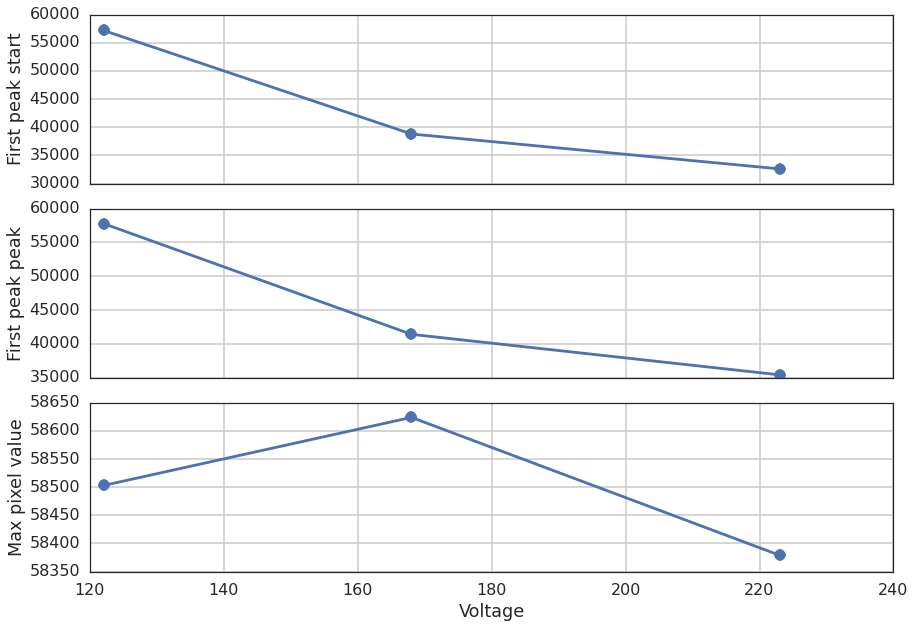

In [15]:
fig, axes = plt.subplots(len(voltages), 1, sharex=True)
axes[0].plot(voltages, first_peak_start, 'o-')
axes[1].plot(voltages, first_peak_peak, 'o-')
axes[2].plot(voltages, max_pixel_count, 'o-')
axes[-1].set(xlabel='Voltage')
labels = ['First peak start', 'First peak peak', 'Max pixel value']
for (label, axis) in zip(labels, axes):
    axis.set_ylabel(label)
    axis.grid(True)
fig.tight_layout()

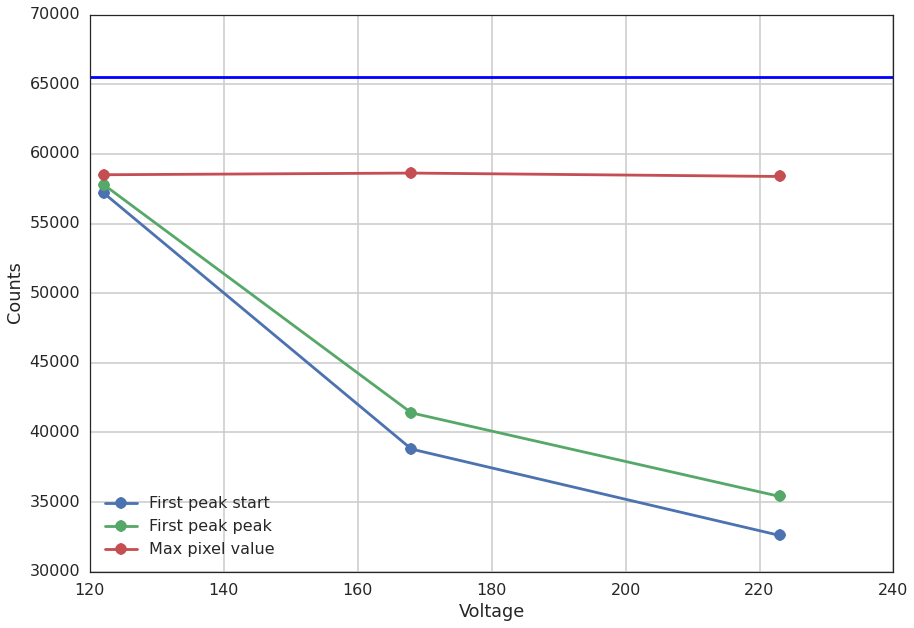

In [22]:
fig, axis = plt.subplots()
axis.plot(voltages, first_peak_start, 'o-', label='First peak start')
axis.plot(voltages, first_peak_peak, 'o-', label='First peak peak')
axis.plot(voltages, max_pixel_count, 'o-', label='Max pixel value')
axis.axhline(2 ** 16 - 1)
axis.set(xlabel='Voltage', ylabel='Counts')
axis.grid(True)
axis.legend(loc='best')
fig.tight_layout()

##  Charge conservation

* Plot the flux values of stars in one voltage against the other as a function of flux in one of the images, e.g. (flux(223) / flux(168) / flux(168)).

In [17]:
for key in image_ids:
    with fits.open(key) as infile:
        imagelist = infile['imagelist'].data
        ind = np.where(imagelist['image_id'] == image_ids[key]['image_id'])[0][0]
        flux = image_ids[key]['flux'] = infile['flux'].section[:, ind]

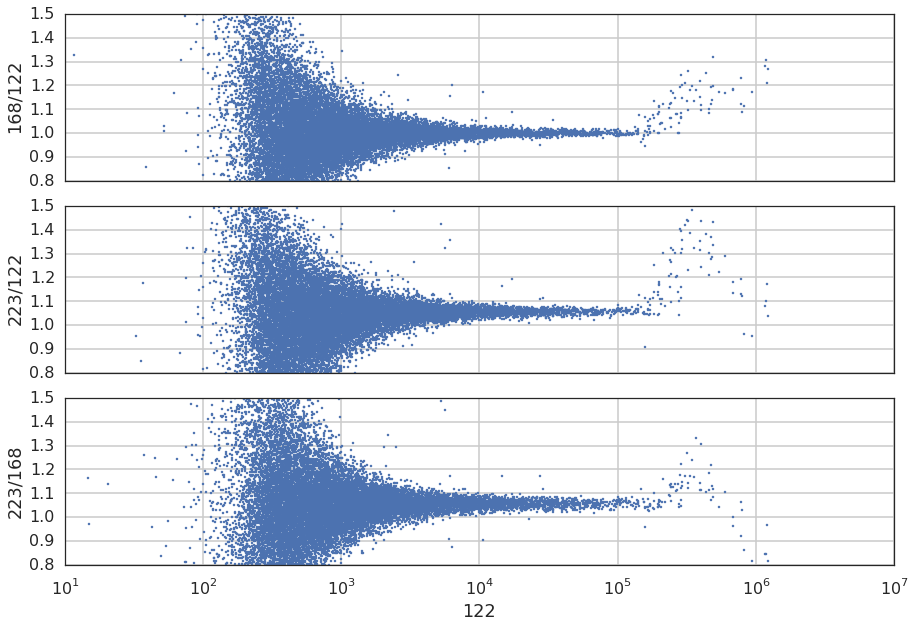

In [18]:
def plot(ax, x, y):
    ax.semilogx(x, y, '.', ms=5)
    
    
fig, axes = plt.subplots(3, 1, sharex=True)
x = image_ids['data/122.fits']['flux']
y = image_ids['data/168.fits']['flux'] / x
plot(axes[0], x, y)
axes[0].set(ylabel='168/122')

x = image_ids['data/122.fits']['flux']
y = image_ids['data/223.fits']['flux'] / x
plot(axes[1], x, y)
axes[1].set(ylabel='223/122')


x = image_ids['data/122.fits']['flux']
y = image_ids['data/223.fits']['flux'] / image_ids['data/168.fits']['flux']
plot(axes[2], x, y)
axes[2].set(ylabel='223/168')

axes[-1].set(xlabel='122')

for ax in axes:
    ax.grid(True)
    ax.set(xlim=(1E1, 1E7), ylim=(0.8, 1.5))
fig.tight_layout()